<a href="https://colab.research.google.com/github/custom-hyper/Analytics/blob/main/Screener.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Infra

Change Requests:
* Remove zeros of market capitalization
* Combine with other tables that don't often update but are useful for research

In [1]:
#@title Connect to FNS { display-mode: "code" }
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title pip 
!pip install pytrends --quiet
!pip install pycoingecko --quiet
!pip install pandas --quiet
!pip install requests --quiet
!pip install pipreqs --quiet
!pip install configparser --quiet
!pip install psycopg2-binary==2.8.6 --quiet

!pip install matplotlib --quiet
!pip install mplfinance --quiet

In [3]:
#@title Ta-lib – Extra steps { display-mode: "code" }
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

(Reading database ... 124017 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#@title Import Project  Dependencies { display-mode: "code" }
import requests
import mplfinance as fplt
from datetime import datetime as dt
from datetime import timedelta
from datetime import date
import talib as ta
import time
import json
import seaborn as sns
from google.colab import data_table
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import logging
import sys
from tqdm.notebook import tqdm
import os
import sqlite3 as sq
import psycopg2 as pg
import configparser
from sqlalchemy import create_engine
from pycoingecko import CoinGeckoAPI
import numpy as np
#from __future__ import division

## Setup SQLite


In [5]:
#@title  Connect { display-mode: "code" }
path = '/content/drive/MyDrive/workspace/pipelines/db/' #@param {type: 'string'
database = "db.sqlite" #@param {type: 'string'
conn_SQLite = sq.connect(path+database)

In [6]:
#@title   Show Available Tables { display-mode: "code" }
cursor = conn_SQLite.cursor()

%time
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
#cursor.execute("DROP TABLE 'proprietary_Twitter_Partnership_ohlc';")
cursor.fetchall()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


[('deFi_lama_total_TVL',),
 ('proprietary_Twitter_Partnership_ohlc',),
 ('proprietary_master_id',),
 ('CoinGecko_ohlc',),
 ('proprietary_tweets_extract',),
 ('proprietary_Twitter_partnerships_announcements',),
 ('proprietary_dashboard',),
 ('watchlist_CoinGecko_ohlc',),
 ('deFi_lama_tvl',),
 ('testing',),
 ('proprietary_airtable_watch_all',),
 ('deFi_lama_general',),
 ('proprietary_Twitter_id',),
 ('CoinGecko_main',),
 ('cal_mvp',),
 ('proprietary_economic_announcement',),
 ('ftx_subaccount_nickname',),
 ('ftx_subaccount_balances',),
 ('ftx_account',),
 ('ftx_positions',),
 ('ftx_wallet_coins',),
 ('ftx_wallet_deposits',),
 ('ftx_wallet_withdrawals',),
 ('ftx_orders_history',),
 ('ftx_fills',),
 ('ftx_funding_payments',),
 ('ftx_balancess',),
 ('ftx_markets',),
 ('ftx_futures',),
 ('CoinGecko_currencies',),
 ('CoinGecko_global',),
 ('CoinGecko_asset_platforms',),
 ('proprietary_screener s',),
 ('proprietary_screener_hist',),
 ('proprietary_screener_ohlc',),
 ('CoinGecko_derivatives',),

# Extract Data

Data source: [CoinGecko API wrapper](https://github.com/man-c/pycoingecko)

In [7]:
#@title Main – Extract { display-mode: "code" }

frames = []
cg = CoinGeckoAPI()

try:

  start =  1
  ends = 20

  for i in tqdm(range(start,ends)):

    output = cg.get_coins_markets(vs_currency='usd', page = i)
    
    data = pd.json_normalize(output,max_level=4)
    frames.append(data)
    time.sleep(10)

except ConnectionError:
    time.sleep(60)

full_table = pd.concat(frames) #Careful, this line must be outside of the for loop




  0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 99
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1900 non-null   object 
 1   symbol                            1900 non-null   object 
 2   name                              1900 non-null   object 
 3   image                             1900 non-null   object 
 4   current_price                     1900 non-null   float64
 5   market_cap                        1900 non-null   int64  
 6   market_cap_rank                   1900 non-null   int64  
 7   fully_diluted_valuation           1167 non-null   float64
 8   total_volume                      1900 non-null   float64
 9   high_24h                          1853 non-null   float64
 10  low_24h                           1853 non-null   float64
 11  price_change_24h                  1853 non-null   float64
 12  price_ch

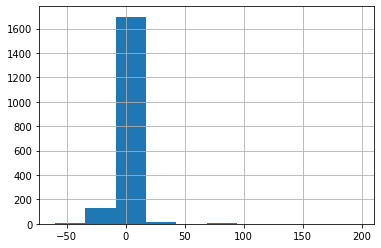

In [9]:
full_table['price_change_percentage_24h'].hist()

In [21]:
#0 division function
def zerodiv(x,y):
    try:
        return x/y
    except ZeroDivisionError:
        return 0


#@title Main – Wrangling{ display-mode: "code" }
full_table['price_range_percent_24h'] =  (full_table['high_24h'] - full_table['low_24h'] ) / 0.5*(full_table['high_24h'] + full_table['low_24h'] ) 
full_table['circulating_cap'] = full_table['current_price'] * full_table['circulating_supply']
full_table['total_cap'] = full_table['current_price'] * full_table['total_supply']
full_table['max_cap'] = full_table['current_price'] * full_table['max_supply']
full_table['price_change_percentage_24h'] = round(full_table['price_change_percentage_24h'], 5)/100
full_table['ath_change_percentage'] = full_table['ath_change_percentage']/100
full_table['market_cap_change_percentage_24h'] = full_table['market_cap_change_percentage_24h']/100
full_table['atl_change_percentage'] = full_table['atl_change_percentage']/100
full_table['dilution_change_percentage_24h'] = full_table['market_cap_change_percentage_24h'] - full_table['price_change_percentage_24h']
full_table['prop_timestamp'] = int( time.time_ns() / 1000 )
full_table['prop_timestamp'] = full_table['prop_timestamp'].astype(np.int8)
full_table['CoinGecko_link'] = str('https://www.coingecko.com/en/coins/') + full_table['id']
full_table['symbol'] = full_table['symbol'].str.upper()
full_table['dilution_ratio'] = zerodiv(full_table['max_supply'],full_table['circulating_supply'])
        
#full_table['dilution_ratio'] = full_table['max_supply'] / full_table['circulating_supply']
full_table['float_rotation_24h'] = zerodiv(full_table['total_volume'],full_table['market_cap'])
full_table['price_change_percentage_24h']  = full_table['price_change_percentage_24h']

#Ranking
full_table['price_range_percent_24h_rank']  =  full_table['price_range_percent_24h'].rank(pct=True)
full_table['total_volume_rank_pct']  =  full_table['total_volume'].rank(pct=True)
full_table['dilution_change_percentage_24h_rank_pct'] = full_table['dilution_change_percentage_24h'].rank(pct=True)
full_table['circulating_cap_rank_pct'] = full_table['circulating_cap'].rank(pct=True)
full_table['total_cap_rank_pct'] = full_table['total_cap'].rank(pct=True)
full_table['max_cap_rank_pct'] = full_table['max_cap'].rank(pct=True)
full_table['price_change_percentage_24h_rank_pct'] = full_table['price_change_percentage_24h'].rank(pct=True)
full_table['market_cap_change_percentage_24h_rank_pct'] = full_table['market_cap_change_percentage_24h'].rank(pct=True)
full_table['market_cap_rank_pct'] = full_table['market_cap'].rank(pct=True)
#full_table['dilution_ratio_rank_pct'] = full_table['dilution_ratio'].rank(pct=True)
#full_table['float_rotation_24h_rank_pct'] = full_table['float_rotation_24h'].rank(pct=True)

#Date
full_table['date'] = date.today()

full_table.replace([np.inf, -np.inf], np.nan, inplace=True)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
full_table


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,price_range_percent_24h_rank,total_volume_rank_pct,dilution_change_percentage_24h_rank_pct,circulating_cap_rank_pct,total_cap_rank_pct,max_cap_rank_pct,price_change_percentage_24h_rank_pct,market_cap_change_percentage_24h_rank_pct,market_cap_rank_pct,date
0,bitcoin,BTC,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,16170.760000,311409901441,1,3.402639e+11,2.472348e+10,16600.080000,...,0.994603,0.999474,0.443243,1.000000,0.999459,1.000000,0.556935,0.573434,1.000000,2022-11-28
1,ethereum,ETH,Ethereum,https://assets.coingecko.com/coins/images/279/...,1171.320000,141391439448,2,1.413914e+11,6.727503e+09,1218.360000,...,0.987048,0.998421,0.612973,0.999474,0.998378,NaN,0.388019,0.388229,0.999474,2022-11-28
2,tether,USDT,Tether,https://assets.coingecko.com/coins/images/325/...,1.000000,65372066430,3,6.537207e+10,3.437488e+10,1.008000,...,0.715057,1.000000,0.203784,0.998421,0.997837,NaN,0.796546,0.785097,0.998947,2022-11-28
3,binancecoin,BNB,BNB,https://assets.coingecko.com/coins/images/825/...,292.520000,47893542150,4,5.866540e+10,1.190268e+09,314.580000,...,0.980032,0.996316,0.841081,0.997895,0.997296,0.998188,0.159741,0.170086,0.998421,2022-11-28
4,usd-coin,USDC,USD Coin,https://assets.coingecko.com/coins/images/6319...,1.000000,44261728619,5,4.426140e+10,2.480872e+09,1.005000,...,0.692930,0.997895,0.217297,0.997368,0.996755,NaN,0.782515,0.795896,0.997895,2022-11-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,dav,DAV,DAV Network,https://assets.coingecko.com/coins/images/2842...,0.001258,872714,1898,NaN,1.258146e-02,0.001258,...,0.046951,0.008421,0.191351,0.012105,0.074094,NaN,0.808419,0.806156,0.002632,2022-11-28
96,wanaka-farm,WANA,Wanaka Farm,https://assets.coingecko.com/coins/images/1802...,0.010103,871550,1897,NaN,1.521750e+03,0.010337,...,0.226659,0.126842,0.391892,0.011579,0.258518,NaN,0.608203,0.593413,0.002105,2022-11-28
97,swapfolio,SWFL,Swapfolio,https://assets.coingecko.com/coins/images/1226...,0.031152,871094,1900,NaN,1.337608e+04,0.031475,...,0.405828,0.243158,0.083243,0.011053,0.013521,NaN,0.916352,0.913067,0.001579,2022-11-28
98,sync-network,SYNC,Sync Network,https://assets.coingecko.com/coins/images/1323...,0.007398,867622,1901,NaN,1.491890e+04,0.007641,...,0.263357,0.260000,0.063243,0.010526,0.029205,NaN,0.936859,0.932505,0.001053,2022-11-28


In [11]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 99
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         1900 non-null   object 
 1   symbol                                     1900 non-null   object 
 2   name                                       1900 non-null   object 
 3   image                                      1900 non-null   object 
 4   current_price                              1900 non-null   float64
 5   market_cap                                 1900 non-null   int64  
 6   market_cap_rank                            1900 non-null   int64  
 7   fully_diluted_valuation                    1167 non-null   float64
 8   total_volume                               1900 non-null   float64
 9   high_24h                                   1853 non-null   float64
 10  low_24h                   

In [12]:

proprietary_screener = "proprietary_screener"

full_table.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

main = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

main.head()


,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,price_range_percent_24h_rank,total_volume_rank_pct,dilution_change_percentage_24h_rank_pct,circulating_cap_rank_pct,total_cap_rank_pct,max_cap_rank_pct,price_change_percentage_24h_rank_pct,market_cap_change_percentage_24h_rank_pct,market_cap_rank_pct,date
0,0chain,ZCN,Zus,https://assets.coingecko.com/coins/images/4934...,0.219322,10636363,809,NaN,21909.00,0.235558,...,0.668106,0.304737,0.632432,0.582105,0.773391,NaN,0.368052,0.427106,0.574737,2022-11-28
1,0x,ZRX,0x,https://assets.coingecko.com/coins/images/863/...,0.183832,156156849,173,184256726.0,11188271.00,0.196807,...,0.630869,0.917895,0.865405,0.910000,0.859383,0.831522,0.135456,0.153348,0.909474,2022-11-28
2,1-up,1-UP,1-UP,https://assets.coingecko.com/coins/images/1737...,0.014725,886431,1892,1104622.0,4889.96,0.016149,...,0.333513,0.178947,0.876757,0.015789,0.014062,0.010870,0.124123,0.122030,0.006316,2022-11-28
3,1337,1337,Elite,https://assets.coingecko.com/coins/images/686/...,0.000031,921458,1869,NaN,11.79,0.000031,...,0.050189,0.028421,0.001081,0.026316,0.010276,NaN,0.999460,0.999460,0.016316,2022-11-28
4,1art,1ART,OneArt,https://assets.coingecko.com/coins/images/1930...,0.016026,2110394,1440,16026303.0,34795.00,0.016299,...,0.303292,0.353684,0.347027,0.251579,0.170903,0.406703,0.652995,0.644168,0.242632,2022-11-28


,id,name,market_cap,market_cap_change_24h,content,volume_24h,updated_at
0,heco-chain-ecosystem,HECO Chain Ecosystem,1.391097e+08,-10.344691,None,2.212748e+07,2022-11-28T18:10:19.381Z
1,fan-token,Fan Token,2.583634e+08,-8.162336,None,7.888048e+07,2022-11-28T18:10:16.210Z
2,social-money,Social Money,6.651159e+07,-7.851306,None,1.021267e+06,2022-11-28T18:10:37.789Z
3,metagovernance,Metagovernance,3.538682e+08,-5.970967,Metagovernance refers to projects or protocols...,6.071183e+06,2022-11-28T18:10:52.754Z
4,centralized-exchange-token-cex,Centralized Exchange (CEX),6.132461e+10,-5.471816,These utility tokens are issued by a centraliz...,8.867543e+08,2022-11-28T18:10:18.091Z
...,...,...,...,...,...,...,...
81,gaming,Gaming (GameFi),7.118281e+09,1.725031,,1.031493e+09,2022-11-28T18:10:56.679Z
82,daomaker-ecosystem,DaoMaker Ecosystem,4.330946e+08,2.196546,None,5.309308e+07,2022-11-28T18:10:22.436Z
83,yearn-yfi-partnerships-mergers,Yearn Ecosystem,6.085012e+08,4.838520,The Yearn Ecosystem is a suite of Decentralize...,1.943159e+08,2022-11-28T18:10:05.437Z
84,meme-token,Meme,1.915840e+10,5.220078,None,2.436577e+09,2022-11-28T18:10:53.065Z


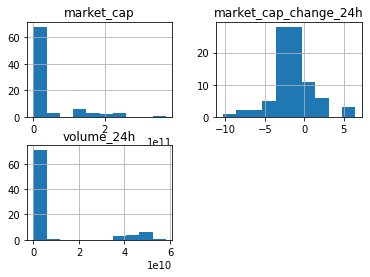

In [13]:
#@title Categories Data { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_coins_categories(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)
del data['top_3_coins']

CoinGecko_derivatives = "CoinGecko_categories"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 
Order by market_cap_change_24h	
""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.hist()
CoinGecko_derivatives




In [14]:
#@title Futures Product { display-mode: "code" }

cg = CoinGeckoAPI()
output = cg.get_derivatives(include_tickers ='unexpired')
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output, columns =(
    ['market', 'symbol', 'index_id', 'price', 'price_percentage_change_24h',
       'contract_type', 'index', 'basis', 'spread', 'funding_rate',
       'open_interest', 'volume_24h', 'last_traded_at', 'last_traded_at_f']))

data['last_traded_at_f'] = pd.to_datetime(data['last_traded_at'], unit='s')
CoinGecko_derivatives = "CoinGecko_derivatives"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)

CoinGecko_derivatives.head()




,market,symbol,index_id,price,price_percentage_change_24h,contract_type,index,basis,spread,funding_rate,open_interest,volume_24h,last_traded_at,last_traded_at_f
0,Deepcoin (Derivatives),ETHUSDT,ETH,1173.96,-3.791742,perpetual,1170.366700,0.056998,0.03,0.007327,3.313393e+09,5.166737e+08,1669659082,2022-11-28 18:11:22
1,BingX (Futures),BTC-USDT,BTC,16181.13,-2.104627,perpetual,16188.900000,0.011738,0.01,0.007200,2.860001e+09,3.925165e+09,1669658679,2022-11-28 18:04:39
2,Bitget Futures,BTCUSDT_UMCBL,BTC,16175.53,-2.167669,perpetual,16187.447979,0.046032,0.01,0.000100,2.471503e+09,3.482565e+09,1669659611,2022-11-28 18:20:11
3,Binance (Futures),BTCUSDT,BTC,16167.29,-2.167048,perpetual,16176.048165,0.029980,0.01,0.005464,2.030568e+09,8.267872e+09,1669659765,2022-11-28 18:22:45
4,Binance (Futures),ETHUSDT,ETH,1169.46,-3.786869,perpetual,1170.358319,0.052860,0.01,-0.003137,1.390403e+09,6.830344e+09,1669659765,2022-11-28 18:22:45


In [15]:
output = cg.get_derivatives_exchanges()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

#@title Futures Exchanges { display-mode: "code" }

CoinGecko_derivatives = "CoinGecko_derivatives_exchange_list"

data.to_sql(CoinGecko_derivatives, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_derivatives = pd.read_sql("""
select *
from {} 

""".format(CoinGecko_derivatives), conn_SQLite)
CoinGecko_derivatives.head()

,name,id,open_interest_btc,trade_volume_24h_btc,number_of_perpetual_pairs,number_of_futures_pairs,image,year_established,country,description,url
0,Binance (Futures),binance_futures,430412.26,2383021.67,237,42,https://assets.coingecko.com/markets/images/46...,2019.0,None,,https://www.binance.com/
1,BingX (Futures),bingx_futures,295094.66,397928.43,155,0,https://assets.coingecko.com/markets/images/91...,NaN,None,"Founded in 2018, BingX is a crypto social trad...",https://bingx.com/
2,BTCEX (Futures),btcex_futures,261216.39,766661.17,84,0,https://assets.coingecko.com/markets/images/75...,NaN,None,,https://www.btcex.com/en-us/
3,Bitget Futures,bitget_futures,235588.67,406706.26,108,0,https://assets.coingecko.com/markets/images/59...,NaN,None,,https://www.bitget.com/en/
4,BTCC Futures,btcc_futures,231070.97,584396.71,11,63,https://assets.coingecko.com/markets/images/84...,2011.0,None,,https://www.btcc.com/en-US/trade/



Reusable scripts

Short
```
WHERE
market_cap > 100000000
AND
dilution_ratio > 6;
```
Long
```
WHERE
price_change_percentage_24h > '2.0e-01'
AND
float_rotation_24h >  0.2
AN
dilution_ratio <  5
```

In [18]:
#@title OHLC { display-mode: "code" }


proprietary_master_id  = "proprietary_screener"

base = pd.read_sql(
"""
SELECT
id,
market_cap,
price_change_percentage_24h,
float_rotation_24h,
dilution_ratio

FROM {}

WHERE
price_change_percentage_24h > 0.1

;
""".format(proprietary_master_id), conn_SQLite)

base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           337 non-null    object 
 1   market_cap                   337 non-null    int64  
 2   price_change_percentage_24h  337 non-null    float64
 3   float_rotation_24h           337 non-null    float64
 4   dilution_ratio               182 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 13.3+ KB


In [17]:
from talib.abstract import *

cg = CoinGeckoAPI()
CoinGecko_id = base['id']
frames = []

try:

  start = 0
  ends = len(CoinGecko_id)
  
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_ohlc_by_id(id=i, vs_currency='usd', days = 'max')

    df = pd.DataFrame(data=a, columns = ['date','open','high', 'low', 'close'])

    df['datetime'] = pd.to_datetime(df['date'], unit='ms')
    df['id'] = str(i)
    df['sma10'] = SMA(df, timeperiod=10,price='close') # calculate on close prices by default
    df['sma20'] = SMA(df, timeperiod=20,price='close') # calculate on close prices by default
    df['sma50'] = SMA(df, timeperiod=50,price='close') # calculate on close prices by default
    df['sma100'] = SMA(df, timeperiod=100,price='close') # calculate on close prices by default
    df['sma200'] = SMA(df, timeperiod=200,price='close') # calculate on close prices by default
    df['atr'] = ATR(df, timeperiod=20) # calculate on close prices by default

    trace1 = {
    'x': df.datetime,
    'open': df.open,
    'close': df.close,
    'high': df.high,
    'low': df.low,
    'type': 'candlestick',
    'name': str(i).upper(),
    'showlegend': True
    }


    trace2 = {
        'x': df.datetime,
        'y': df.sma10,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'yellow'
                },
        'name': 'SMA 10'
    }

    trace3 = {
        'x': df.datetime,
        'y': df.sma20,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'orange'
        },
        'name': 'SMA 20'
    }
    trace4 = {
        'x': df.datetime,
        'y': df.sma50,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'green'
                },
        'name': 'SMA 50'
    }

    trace5 = {
        'x': df.datetime,
        'y': df.sma100,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'blue'
        },
        'name': 'SMA 100'
    }
    trace6 = {
        'x': df.datetime,
        'y': df.sma200,
        'type': 'scatter',
        'mode': 'lines',
        'line': {
            'width': 1,
            'color': 'purple'
        },
        'name': 'SMA 200'
    }

    data = [trace1, trace2, trace3,trace4,trace5,trace6]

    # Config graph layout
    layout = go.Layout({
        'title': {
            'text': str(i).upper().replace("-"," ") + ' Moving Averages',
            'font': {
                'size': 15
            }
        }
    })

              
      #CHARTING
    fig = go.Figure(data=data, layout=layout)
    fig.show()


    CoinGeckoAPI
    #time.sleep(60/50)
    frames.append(df)
    

except ConnectionError:
  time.sleep(60)

single = pd.concat(frames) #Careful, this line must be outside of the for loop
single['prop_timestamp'] = int( time.time_ns() / 1000 )

single['query_date'] = date.today()
fig.write_html("Moving Averages.html")

  0%|          | 0/356 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
single.tail()


In [ ]:
proprietary_screener = "proprietary_screener_ohlc"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

ohlc = pd.read_sql('select * from {} GROUP BY id'.format(proprietary_screener), conn_SQLite)

ohlc

In [ ]:
#@title Other Historical { display-mode: "code" }
from talib.abstract import *
import pandas as pd
import numpy as np

cg = CoinGeckoAPI()
CoinGecko_id = base['id']
frames = []


try:
  start = 0
  ends = len(CoinGecko_id)
  for i in tqdm(CoinGecko_id[start:ends]):

    a = cg.get_coin_market_chart_by_id(id=i, vs_currency='usd', days = 'max')

    b = a['prices']
    df1 = pd.DataFrame(b, columns = ['date','price'])
    df1['datetime'] = pd.to_datetime(df1['date'], unit='ms')
    df1.set_index("date", inplace = True)

    c = a['market_caps']
    df2 = pd.DataFrame(c, columns = ['date','market_cap'])
    df2.set_index("date", inplace = True)

    d = a['total_volumes']
    df3 = pd.DataFrame(d, columns = ['date','volume'])   
    df3.set_index("date", inplace = True)

    result = pd.concat([df1, df2,df3], ignore_index=False,axis=1)

    result['id'] = i
    result['stdev_30d'] = result['price'].rolling(30).std()
    result['volume_30d'] = result['volume'].rolling(30).mean()
    result['rel_volume'] = result['volume'] / result['volume_30d'] 
    result['float_rotation'] = result['volume'] / result['market_cap'] 
    

    frames.append(result)
    time.sleep(60/50)
except ConnectionError:
    time.sleep(60)
single = pd.concat(frames) #Careful, this line must be outside of the for loop



single.tail()

In [ ]:
from numpy.lib.twodim_base import histogram2d

proprietary_screener = "proprietary_screener_hist"

single.to_sql(proprietary_screener, conn_SQLite, if_exists='replace', index=True) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost. WHERE datetime CONTAINS '2021'

hist = pd.read_sql("""
select 
*
from {}  

Group by id


""".format(proprietary_screener), conn_SQLite)

hist

In [ ]:
#df =  base.join(ohlc)

df1 = base.merge(hist, on='id', how='left')
df2 = df1.merge(ohlc, on='id', how='right')
df2

In [ ]:
#base.set_index("id", inplace = True)
#ohlc.set_index("id", inplace = True)
#hist.set_index("id", inplace = True)

frames = [base,ohlc, hist]

#result = pd.concat(frames)
result = pd.merge(frames, how="left", left_on='id', right_on='id')

result

Get CoinGecko Market Data

# Futures Coverage Indicator

In [ ]:
#Query the derivatives table

# Group table By index ID and create a: where if the  contract type includes perpetual, at P Contract type Futures exist, at letter



In [ ]:
proprietary_screener.head()

In [ ]:
proprietary_screener.info()

In [ ]:
#@title Gets Currencies { display-mode: "code" }
output = cg.get_supported_vs_currencies()
data = pd.DataFrame(output, columns =['currencies'])
CoinGecko_currencies = "CoinGecko_currencies"



data.to_sql(CoinGecko_currencies, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_currencies = pd.read_sql('select * from {}'.format(CoinGecko_currencies), conn_SQLite)

In [ ]:
#@title
output = cg.get_derivatives()
data = pd.json_normalize(output,max_level=4)
data

In [ ]:
#@title Get Global Data { display-mode: "code" }

output = cg.get_global()
data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)

CoinGecko_global = "CoinGecko_global"

data.to_sql(CoinGecko_global, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_global = pd.read_sql('select * from {}'.format(CoinGecko_global), conn_SQLite)
CoinGecko_global.info()

In [ ]:
#@title Get Assess platforms { display-mode: "code" }

output = cg.get_asset_platforms()

data = pd.json_normalize(output,max_level=4)
data = pd.DataFrame(output)



CoinGecko_asset_platforms = "CoinGecko_asset_platforms"

data.to_sql(CoinGecko_asset_platforms, conn_SQLite, if_exists='replace', index=False) # writes to file
conn_SQLite.commit()

# Just be sure any changes have been committed or they will be lost.

CoinGecko_asset_platforms = pd.read_sql('select * from {}'.format(CoinGecko_asset_platforms), conn_SQLite)
CoinGecko_asset_platforms.info()

**bold text**# Create Features

In [ ]:
#@title
# Just be sure any changes have been committed or they will be lost.
conn_SQLite.close()

# Backtesting

# Chartbook
